In [418]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split, GridSearchCV

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')


In [419]:
df_train = pd.read_csv('TrainPoverty.csv')
df_test = pd.read_csv('TestPoverty.csv')

Data Exploration:

In [420]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [421]:
df_train.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,...,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,1.036574,...,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
25%,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,16.000000,289.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,289.000000,3.000000
50%,1.300000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,36.000000,961.000000,16.000000,36.000000,1.000000,2.250000,0.444444,81.000000,961.000000,4.000000
75%,2.000000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,...,121.000000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,134.560010,2601.000000,4.000000
max,2.353477e+06,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,8.000000,...,441.000000,9409.000000,169.000000,441.000000,81.000000,36.000000,64.000000,1369.000000,9409.000000,4.000000


Well it looks like the variable names are in Spanish, and that some values are missing. I'll definitely need to use the data description to understand what is meant by the variable names. On top of that the competition outlines that I need predict poverty scores for just the head of household so we'll need to group the data by the household somehow. First lets look at the distribution of classes for some backgroun info.

In [422]:
y = df_train['Target']
x = df_train.drop(['Target'], 1)

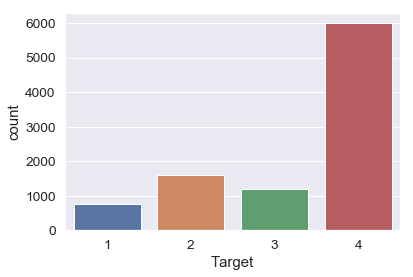

In [423]:
sns.countplot(y, None)

So we definitely have unbalance data with a low count of the poverty vulnerable classes. We'll have to implement something in our model to deal with this. Now let's see if any of these classes are mislabelled. If everything is correct then everyone with the same ID should have the same value as the head of household.

### Object Columns

In [424]:
df_train.loc[:, df_train.dtypes == object].head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


Lets map out those yes and no's based on the data description that is given in the competition.

In [425]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [df_train]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

df_train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [426]:
df_train.loc[:, df_train.dtypes == object].head()

,Id,idhogar
0,ID_279628684,21eb7fcc1
1,ID_f29eb3ddd,0e5d7a658
2,ID_68de51c94,2c7317ea8
3,ID_d671db89c,2b58d945f
4,ID_d56d6f5f5,2b58d945f


This is exactly what we want to be the object columns so we are done with fixing the other variables!

### Conflicting poverty values in households

In [427]:
equal = df_train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
not_equal = equal[equal != True]
len(not_equal)

85

So we have 85 households with mismatched poverty levels. Since there aren't that many of them I think assigning the household the poverty level that is assigned to the head is a safe way to deal with this. That of course assumes that no household heads are missing.

In [428]:
missinghead = df_train.groupby('idhogar')['parentesco1'].sum()
#for i in missinghead 

households_no_head = df_train.loc[df_train['idhogar'].isin(missinghead[missinghead == 0].index), :]
households_no_head['idhogar'].nunique()

15

So there are 15 missing heads which means that we'll probably have to throw those observations out, now lets see if any of those heads are missing for households that have conflicting poverty level values.

In [429]:
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
sum(households_no_head_equal == False)
not_equal.head(10)

idhogar
0172ab1d9    False
03f4e5f4d    False
0511912b6    False
078a0b6e2    False
09e25d616    False
0f3e65c83    False
0f9494d3a    False
15a891635    False
17fb04a62    False
18832b840    False
Name: Target, dtype: bool

This is good news because it means that none of the missing heads overlap with the conflicting poverty values! Now lets resolve the conflicting poverty values by replacing them with the head of household's value.

In [430]:
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(df_train[(df_train['idhogar'] == household) & (df_train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    df_train.loc[df_train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = df_train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
len(not_equal)

0

Okay now that we are done with that lets move on to cleaning up some of the missing data!

# Missing data 



It looks like there are 5 variables that are missing. Due to the language barrier I will go look up what each ones means so we know how to best deal with it.
rez_esc is years behind in school for kids age 7-19 and capped at 5
v18q1 is the number of tablets owned in the hosuehold
v2a1 is the monthly rent payment
SQBmeaned is the square of meaneduc
meaneduc is the average education of adults in the home.
Lets start by looking at descriptions of the rez_esc.

In [431]:
missingdata = pd.DataFrame()
#df_train.drop(['Id'], axis=1, inplace=True)
missingdata['total'] = df_train.isnull().sum()
missingdata['percent'] = missingdata['total'] / len(missingdata)
missingdata.sort_values('percent', ascending = False).head(5)

,total,percent
rez_esc,7928,55.440559
v18q1,7342,51.342657
v2a1,6860,47.972028
SQBmeaned,5,0.034965
meaneduc,5,0.034965


### Years Behind in School

In [432]:
df_train.loc[df_train['rez_esc'].notnull()].describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,518.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,397.000000,1629.000000,1629.000000,...,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000
mean,154096.980695,0.060773,4.848373,0.033763,0.992020,0.942296,0.243708,1.458438,0.595457,1.621240,...,33.786372,160.620626,24.451811,51.823818,7.362799,4.307784,2.986629,97.250620,160.620626,3.020872
std,130695.141552,0.238988,1.402776,0.180674,0.089003,0.233255,0.429450,0.804916,0.797880,1.035401,...,30.277988,78.360392,20.812009,79.248522,9.331875,4.946285,6.769571,91.476262,78.360392,1.094236
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,49.000000,4.000000,0.000000,1.000000,0.250000,0.040000,0.000000,49.000000,1.000000
25%,80000.000000,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,4.000000,81.000000,16.000000,0.000000,1.000000,1.777778,0.444444,36.000000,81.000000,2.000000
50%,120000.000000,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,...,25.000000,144.000000,16.000000,25.000000,4.000000,2.777778,1.000000,72.250000,144.000000,3.000000
75%,180000.000000,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,...,49.000000,225.000000,25.000000,64.000000,9.000000,4.000000,2.250000,121.000000,225.000000,4.000000
max,1000000.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,7.000000,...,121.000000,289.000000,169.000000,441.000000,81.000000,36.000000,64.000000,841.000000,289.000000,4.000000


Since this variable is only for people between ages 7-19 then it seems like people who aren't between these ages might just have null values.

In [433]:
df_train[df_train['rez_esc'].notnull()]['age'].describe()

count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [434]:
df_train[df_train['rez_esc'].isnull()]['age'].describe()

count    7928.000000
mean       38.833249
std        20.989486
min         0.000000
25%        24.000000
50%        38.000000
75%        54.000000
max        97.000000
Name: age, dtype: float64

In [435]:
# schlyears = df_train['rez_esc'].copy()
# age = df_train['age'].copy()
# dict1 = {'Years Behind in School': schlyears,
#      'Age': age}
# df = pd.DataFrame(dict1)
# df.plot()
#df_train.loc[df_train['v2a1'].isnull(), own_variables].sum()
# df_train.loc[df_train['age'].values, 'rez_esc']
#index = df_train['age'].unique()
# df_train.loc[df_train['v2a1'].isnull(), age]

#df_train.plot.bar(y='rez_esc', index=index)

Lets reset those values to be zeros and add a flag variable for the people that aren't in the age group for this variable.

In [436]:
df_train.loc[(df_train['rez_esc'].isnull()) & ((df_train['age'] > 17) | (df_train['age'] < 7)), 'rez_esc'] = 0
df_train['rez_esc-missing'] = df_train['rez_esc'].isnull()
df_train['rez_esc'].isnull().sum()

1

Lets see what this random value is that is still null!

In [437]:
df_train.loc[df_train['rez_esc'].isnull()==True, 'age'].item()

10

Lets just fill it in with a zero since its only one observation

In [438]:
df_train.loc[df_train['rez_esc'].isnull()==True, 'rez_esc'] = 0

Now lets see if all of the rez_esc has an outliers.

In [439]:
df_train['rez_esc'].isnull().sum()

0

### Tablets Owned per Household

In [440]:
df_train['v18q1'].describe()

count    2215.000000
mean        1.404063
std         0.763131
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: v18q1, dtype: float64

It seems weird that the lowest number is 1 since a lot of people probably own 0 tablets so thats probably the source of the issue. Lets look at the other variable that is associated with whether the family has a laptop or not.

# Put a plot here!

In [441]:
df_train['v18q1'].isnull().sum()

7342

In [442]:
len(df_train[(df_train['v18q1'].isnull()) & (df_train['v18q']==0)])

7342

This looks hacky but if the number of rows that have null values is the same then it is probably the reason for these null values, so we can just replace those with zeros

In [443]:
df_train.loc[(df_train['v18q1'].isnull()) & (df_train['v18q']==0), 'v18q1'] = 0
df_train['v18q1'].isnull().sum()

0

### Monthly Rent Payment

This variable will probably be a little more involved than the other variables since it seems like it would be really relevant to poverty levels. It also has a set of variables that go with it that might be able to explain the null values.

In [444]:
df_train['v2a1'].isnull().sum()
df_train.loc[df_train['tipovivi1'] == 1, 'v2a1'].isnull().sum()

5911

Let plot the different categories to see if these nan values are just people that have non-rental/mortage housing.

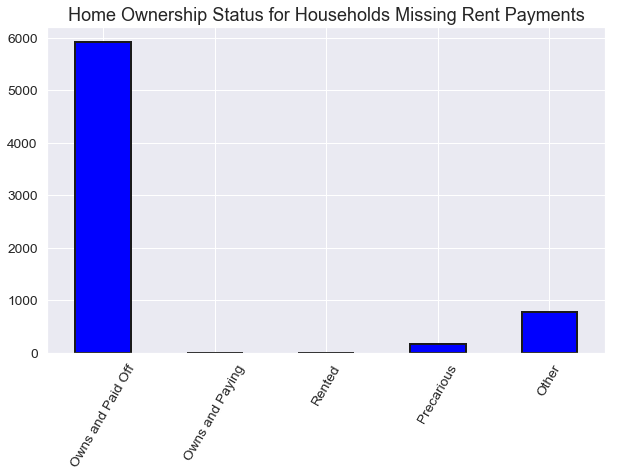

In [445]:
own_variables = [x for x in df_train if x.startswith('tipo')]
own_variables

# Plot of the home ownership variables for home missing rent payments
df_train.loc[df_train['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 6),
                                                                        color = 'blue',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
          ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
         rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

In [446]:
df_train.loc[df_train['v2a1'].isnull(), own_variables].sum().sum()

6860

It appears that all of the null values for the monthly rent payment can be explained by other types of housing options so we can just fill those null values with a zero.

In [447]:
df_train['v2a1-missing'] = df_train['v2a1'].isnull()
df_train['v2a1'].fillna(0, inplace=True)
df_train['v2a1'].isnull().sum()

0

Finally we can throw out the 5 missing values for the other two variables since there are so few of them.

In [448]:
df_train.dropna(inplace=True)

In [449]:
df_train.dropna(inplace=True)
df_train.shape


(9552, 145)

This problem will most likely do best with a decision tree based model and not linear regession so we don't need to worry about the assumptions that come along with that. But we will do some feature engineering to help our model succeed.

# Feature Engineering

Some of the variables are highly correlated with each other and so we should throw those out to help our model. For example all of the squared variables are not needed since we won't be using LR.

In [450]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']
df_train.drop(columns=sqr_, inplace=True)
df_train.shape

(9552, 136)

In [451]:
id_ = ['Id', 'idhogar', 'Target']
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

We also need to aggregate the data to the household level.

In [452]:
heads = df_train.loc[df_train['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(2970, 99)

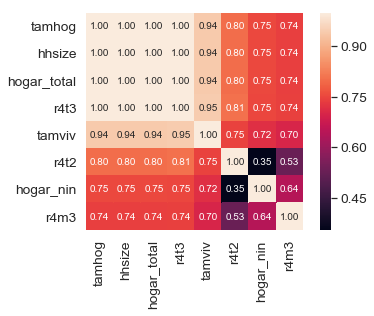

In [453]:
corrmat = heads.corr()
k = 8 #number of variables for heatmap
cols = corrmat.nlargest(k, 'hhsize')['hhsize'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

It seems like we can get rid of some of these redundant variables with in the household size group of features.

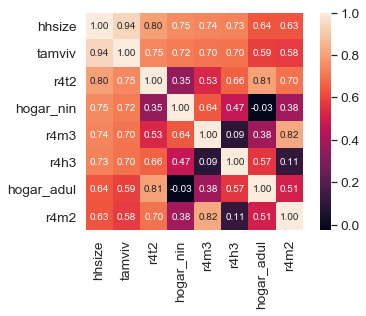

In [454]:
heads.drop(columns=['tamhog', 'hogar_total', 'r4t3'], inplace=True)
corrmat = heads.corr()
k = 8 #number of variables for heatmap
cols = corrmat.nlargest(k, 'hhsize')['hhsize'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

This looks a lot better!

### Aggregating to the Household level:

In [455]:
ind = df_train[id_ + ind_bool + ind_ordered]
ind.shape

(9552, 40)

In [456]:
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ... escolari  \
           min max sum count  std range_ min max sum count  ...      sum   
idhogar                                                     ...            
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...       16   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...       13   
004616164    0   0   0     2  0.0      0   0   0   0     2  ...       14   
004983866    0   0   0     2  0.0      0   0   0   0     2  ...       15   
005905417    0   0   0     3  0.0      0   0   0   0     3  ...       17   

                                  age                                  
          count        std range_ min max sum count        std range_  
idhogar                                                                
001ff74ca     2  11.313708     16   0  38  38     2  26.870058     38  
003123ec2     4   3.774917      7   1  24  51     4  12.446552     23  
004616164     2   5.656854      8  16  50  66     2  24.041631     34  
004983866     2   0.707107      1  16  59  75     2  30.405592     43  
005905417     3   4.932883      9   6  32  52     3  13.316656     26  

[5 rows x 216 columns]

In [457]:
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)
final.info()

Final features shape:  (2970, 312)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2970 entries, 0 to 2969
Columns: 312 entries, Id to (age, range_)
dtypes: bool(1), float64(47), int64(262), object(2)
memory usage: 7.1+ MB


# Modeling!

Now that the data is aggregated we can start running different models on it to see what will work best!

In [458]:
# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extract the training data
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])



In [459]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_set = pipeline.fit_transform(train_set)

In [478]:
x_train, x_test, y_train, y_test = train_test_split(train_set, final['Target'], test_size=0.33, random_state=42)

model1 = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1, class_weight='balanced')
model1.fit(x_train, y_train)
# 10 fold cross validation
cv_score1 = cross_val_score(model1, train_set, train_labels, cv = 5, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score1.mean(), 4)} with std = {round(cv_score1.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3219 with std = 0.0396


In [479]:
model2 = RandomForestClassifier(n_estimators=500, random_state=10, 
                               n_jobs = -1, class_weight='balanced')
model2.fit(x_train, y_train)
# 10 fold cross validation
cv_score2 = cross_val_score(model2, train_set, train_labels, cv = 5, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score2.mean(), 4)} with std = {round(cv_score2.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3249 with std = 0.0421


Well this model isn't the best that we've seen based on the leaderboard but it does seem like a good place to start. It seems that increasing the number of trees isn't helping much so lets try to use some other boosts to it to make it run better.

In [462]:
from xgboost import XGBClassifier

In [472]:
model3 = XGBClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1, class_weight='balanced')
model3.fit(x_train, y_train)
# 10 fold cross validation
cv_score3 = cross_val_score(model3, train_set, train_labels, cv = 5, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score3.mean(), 4)} with std = {round(cv_score3.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.2798 with std = 0.0713


Yikes! Thats performing a lot worse than the random forest was. Lets just use the random forest for our test predictions. 

In [511]:
df_test = df_test = pd.read_csv('TestPoverty.csv')
def transformation(testdata):
    #Object variables
    mapping = {"yes": 1, "no": 0}
    for df in [testdata]:
        # Fill in the values with the correct mapping
        df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
        df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
        df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
        #Years behind in School
    testdata.loc[(testdata['rez_esc'].isnull()) & ((testdata['age'] > 17) | (testdata['age'] < 7)), 'rez_esc'] = 0
    testdata.loc[testdata['rez_esc'].isnull()==True, 'rez_esc'] = 0
    #Tablets
    testdata.loc[(testdata['v18q1'].isnull()) & (testdata['v18q']==0), 'v18q1'] = 0
    #Monthly Rent=
    testdata['v2a1'].fillna(0, inplace=True)
    #Drop squared variables
    testdata.drop(columns=sqr_, inplace=True)
    #Household redundant
    testdata.drop(columns=['tamhog', 'hogar_total', 'r4t3'], inplace=True)
    # Group and aggregate
    ind = df_train[id_ + ind_bool + ind_ordered]
    range_ = lambda x: x.max() - x.min()
    range_.__name__ = 'range_'
    ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
    testdata.drop(columns = ['Id', 'idhogar'], inplace=True)
    testdata.dropna(inplace=True)
    return testdata

In [512]:
df_test = transformation(df_test)
trans_testdata = df_test
test_predictions = model2.predict(trans_testdata)
test_predictions

ValueError: Number of features of the model must match the input. Model n_features is 309 and input n_features is 128 

It seems that the data transformation on the test sset isn't working correctly, unfortunately there isn't enough time for me to be able to fix whatever is going on but with additional time I'm sure it could be figured out.

# Conclusion:

It seems like our prediction came out well and that our models were performing well. To further the power of the models, I would need to take more time to clean the data and create more useful features than the ones that are currently being used. After that I would feel more comfortable using this model in a real life scenario.